In [32]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

#from MyMLP import MyMLP

from hw3_utils import load_MNIST

np.random.seed(2023)

batch_size = 32

normalize_vals = (0.1307, 0.3081)

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

In [33]:
import matplotlib.pyplot as plt

In [34]:
class MyCNN(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride_size, max_pool_size, learning_rate, max_epochs):
        '''
        input_size: [int], feature dimension 
        hidden_size: number of hidden nodes in the hidden layer
        output_size: number of classes in the dataset, 
        learning_rate: learning rate for gradient descent,
        max_epochs: maximum number of epochs to run gradient descent
        '''
        ### Construct your MLP Here (consider the recommmended functions in homework writeup)  
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = kernel_size, padding = 0, bias = True)
        self.pool = nn.MaxPool2d(kernel_size = max_pool_size, stride = stride_size)
        self.drop = nn.Dropout(p = 0.5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(3380, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.input_size = input_size

    def forward(self, x):
        ''' Function to do the forward pass with images x '''
        ### Use the layers you constructed in __init__ and pass x through the network
        ### and return the output
        relu = nn.ReLU()
        x = self.conv1(x)
        x = relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = relu(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x

    def fit(self, train_loader, criterion, optimizer):
        '''
        Function used to train the MLP

        train_loader: includes the feature matrix and class labels corresponding to the training set,
        criterion: the loss function used,
        optimizer: which optimization method to train the model.
        '''
        total, err = 0, 0
        prediction = []
        # Epoch loop
        for i in range(self.max_epochs):

            # Mini batch loop
            for j,(images,labels) in enumerate(train_loader, 0):
                images, labels = (images, labels)
                #images = images.view(-1, 28*28)
                # Forward pass (consider the recommmended functions in homework writeup)
                outputs = self.forward(images)

                # Backward pass and optimize (consider the recommmended functions in homework writeup)
                # Make sure to zero out the gradients using optimizer.zero_grad() in each loop
                optimizer.zero_grad()
                # Track the loss and error rate
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, pred = torch.max(outputs.data, 1)
                prediction.append(pred)
                total += labels.size(0)
                err += (pred != labels).sum().item()
            # Print/return training loss and error rate in each epoch
            print({"loss": round(loss.item(), 4), "err_rate": round(err/total, 4)})

    def predict(self, test_loader, criterion):
        '''
        Function used to predict with the MLP

        test_loader: includes the feature matrix and classlabels corresponding to the test set,
        criterion: the loss function used.
        '''
        total, err = 0, 0
        missed_img = []
        with torch.no_grad(): # no backprop step so turn off gradients
            for j,(images,labels) in enumerate(test_loader, 0):
                images, labels = (images, labels)
                #images = images.view(-1, 28*28)
                #labels_np = labels.numpy()
                #label_full = np.hstack((label_full, labels_np))
                # Compute prediction output and loss
                outputs = self.forward(images)
                # Measure loss and error rate and record
                loss = criterion(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                #pred_np = pred.numpy()
                #prediction = np.hstack((prediction, pred_np))
                total += labels.size(0)
                err += (pred != labels).sum().item()
                missed_img.append(torch.squeeze(images[pred != labels]))
        # Print/return test loss and error rate
        print({"loss": round(loss.item(), 4), "err_rate": round(err/total, 4)})
        
        ind = []
        for i in range(len(missed_img)):
            ind.append(missed_img[i].shape[0] == np.sqrt(self.input_size))
        ind = np.asarray(ind)
        missed_img = np.asarray(missed_img)
        missed_img_new = missed_img[ind]

        return pred, missed_img_new

In [35]:
lr = [0.1]
criterion = nn.CrossEntropyLoss()
print('SGD')
for i in range(len(lr)):
    print(lr[i])
    cnn = MyCNN(input_size=28*28, output_size=10, kernel_size=3, stride_size=2, max_pool_size=2, learning_rate=lr[i], max_epochs=10)
    optim_sgd = torch.optim.SGD(cnn.parameters(), lr = lr[i])
    cnn_sgd = cnn.fit(train_loader = train_loader, criterion = criterion, optimizer = optim_sgd)
    cnn_sgd
    print("test")
    test_cnn_sgd, missed_img = cnn.predict(test_loader = test_loader, criterion = criterion)
    test_cnn_sgd
    

SGD
0.1
{'loss': 0.0626, 'err_rate': 0.1025}
{'loss': 0.0771, 'err_rate': 0.0767}
{'loss': 0.0828, 'err_rate': 0.0661}
{'loss': 0.0856, 'err_rate': 0.0592}
{'loss': 0.0084, 'err_rate': 0.0546}
{'loss': 0.0116, 'err_rate': 0.0513}
{'loss': 0.0222, 'err_rate': 0.0486}
{'loss': 0.0486, 'err_rate': 0.0465}
{'loss': 0.0019, 'err_rate': 0.0446}
{'loss': 0.0271, 'err_rate': 0.043}
test
{'loss': 0.0516, 'err_rate': 0.033}


/tmp/ipykernel_179417/2774307314.py:105: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  missed_img = np.asarray(missed_img)
/tmp/ipykernel_179417/2774307314.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  missed_img = np.asarray(missed_img)


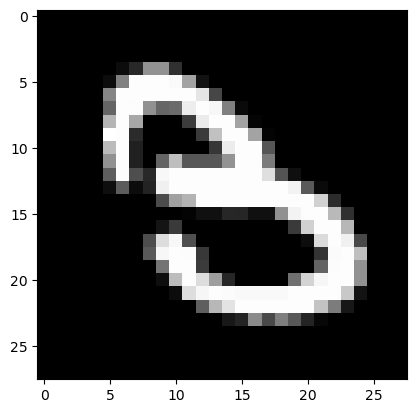

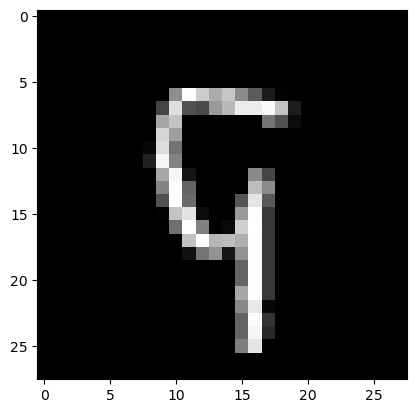

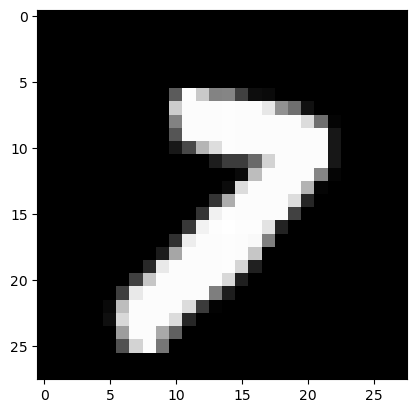

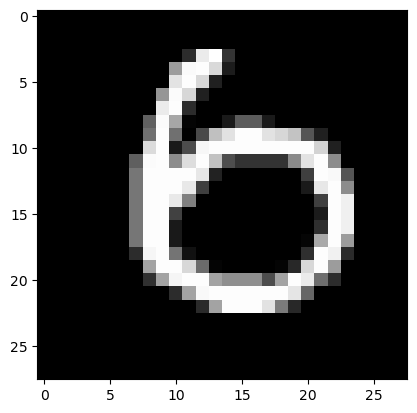

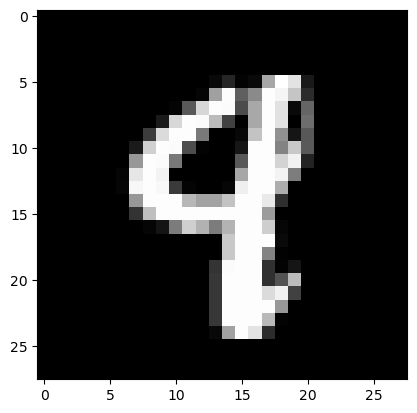

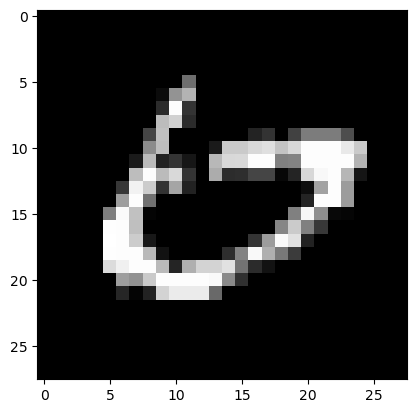

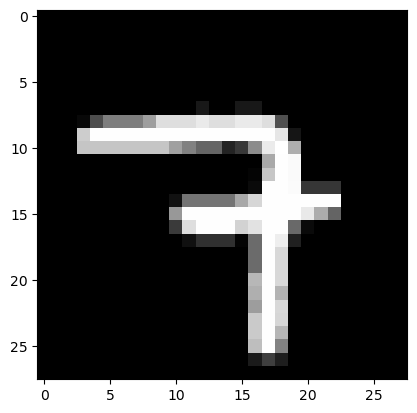

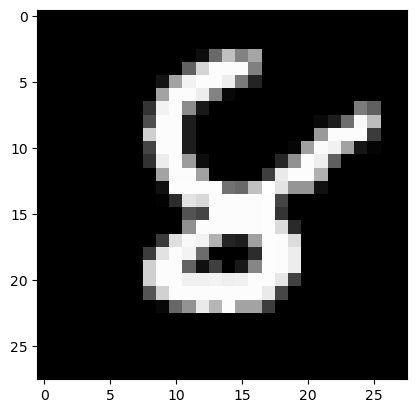

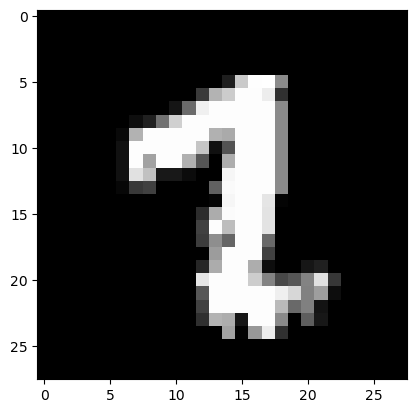

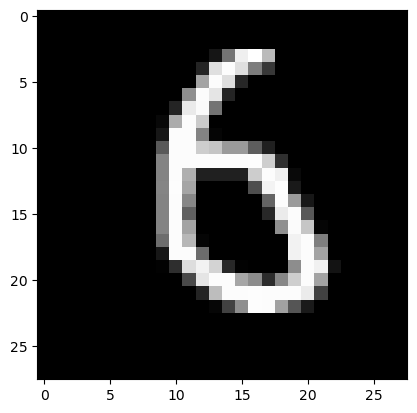

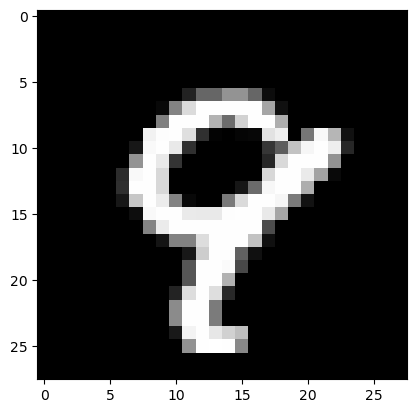

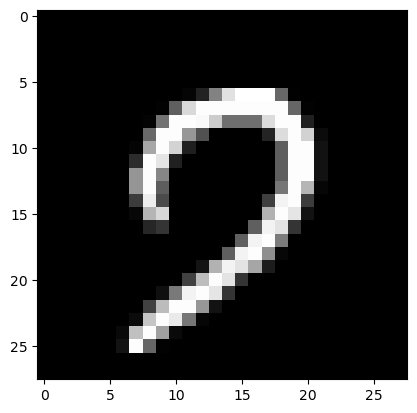

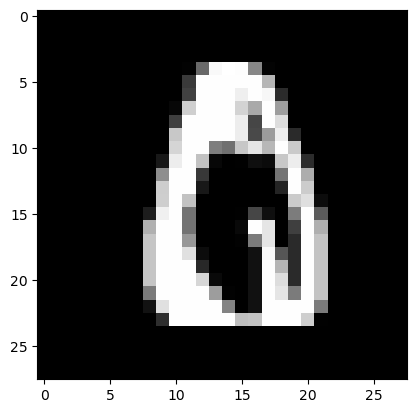

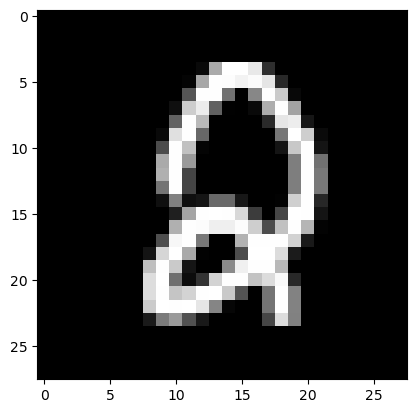

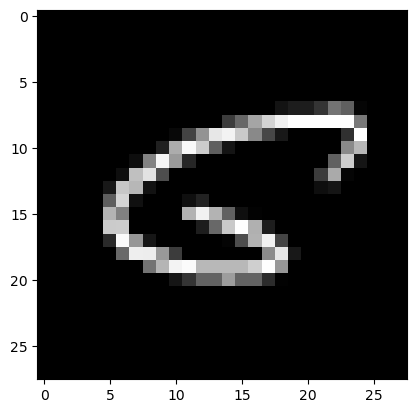

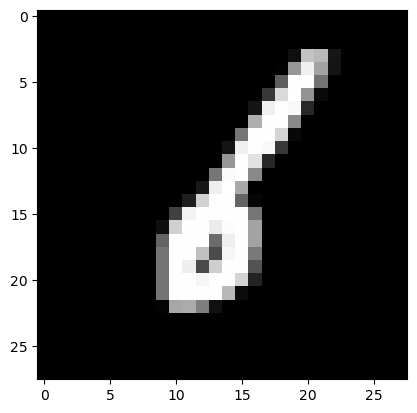

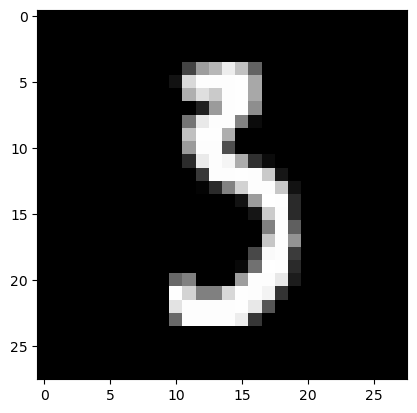

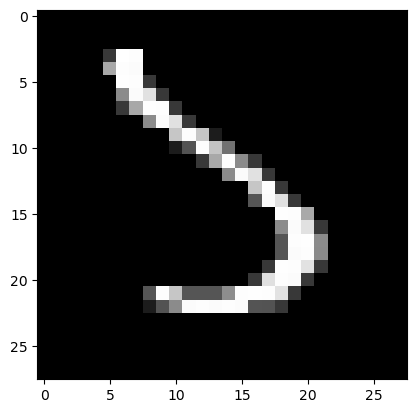

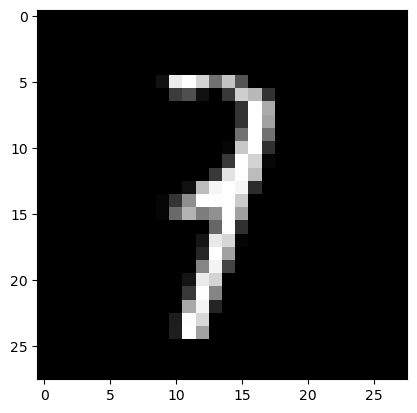

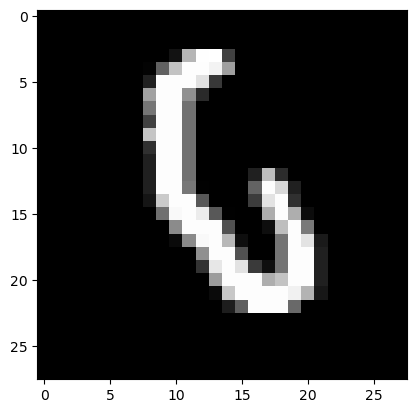

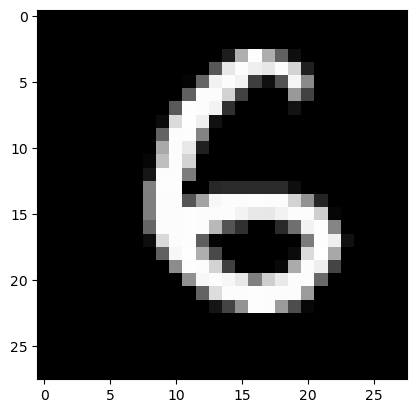

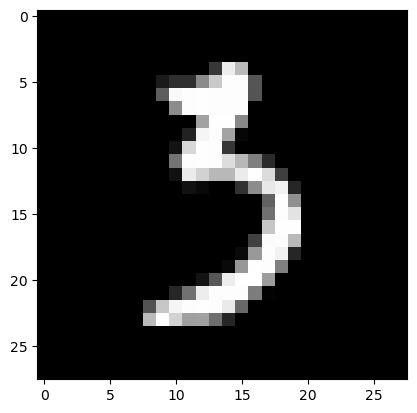

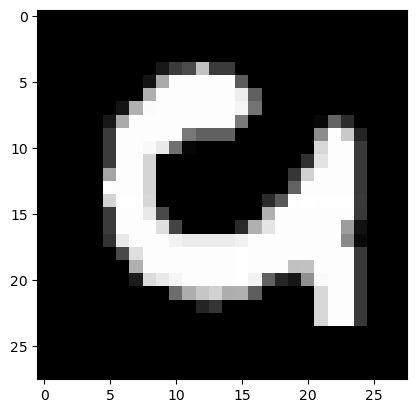

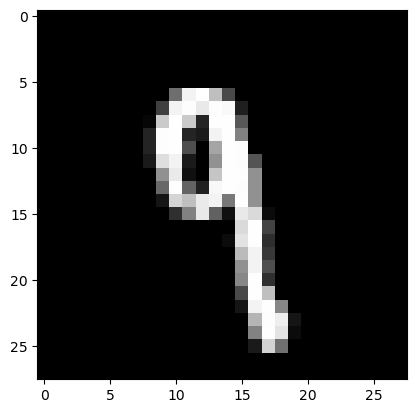

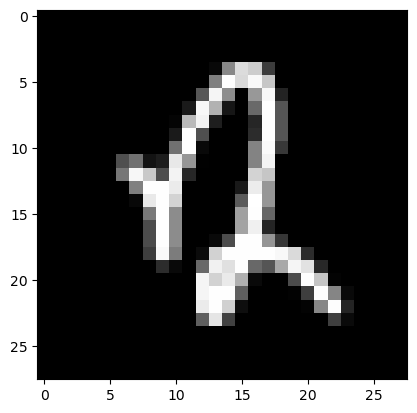

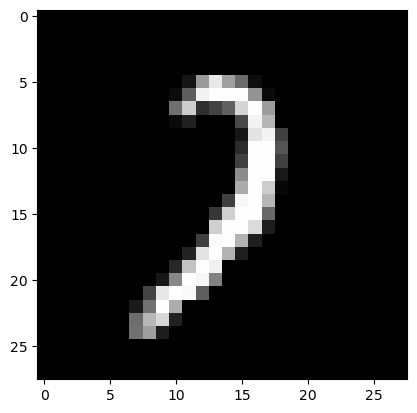

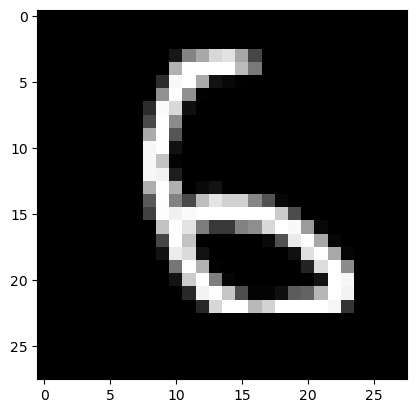

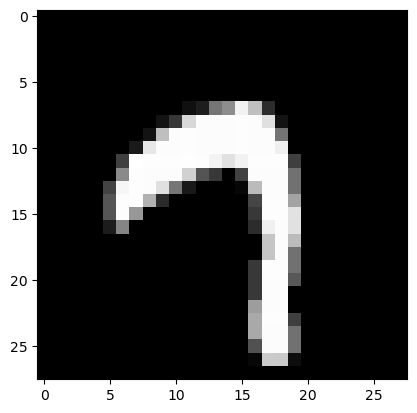

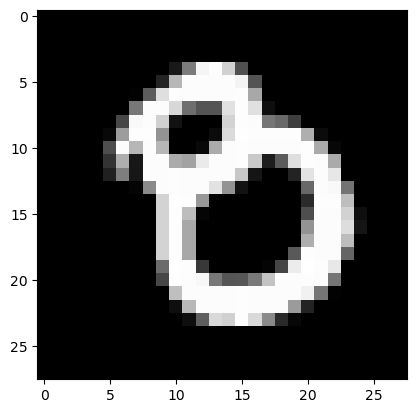

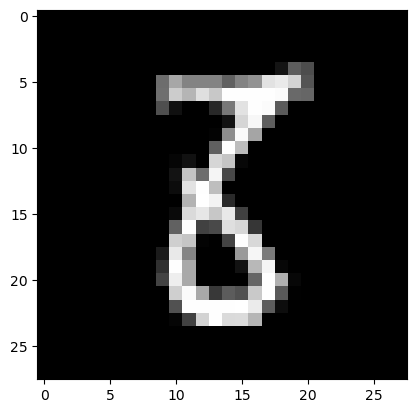

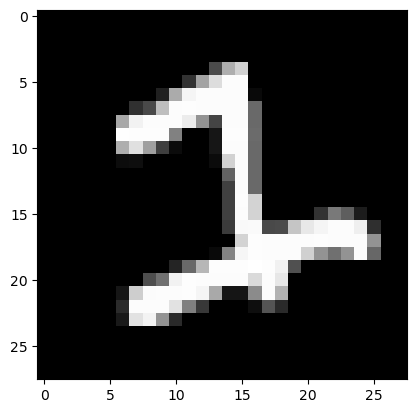

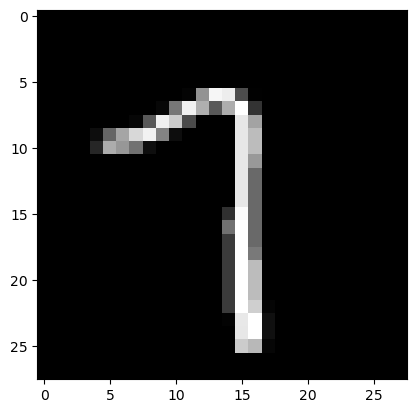

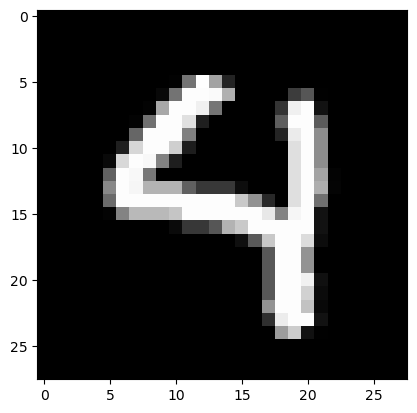

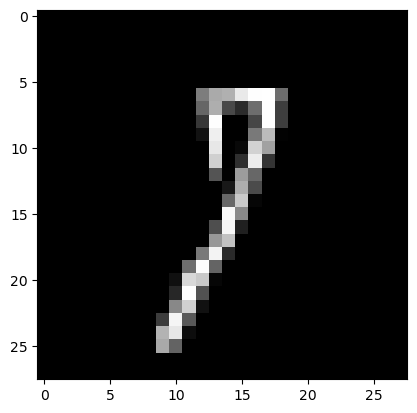

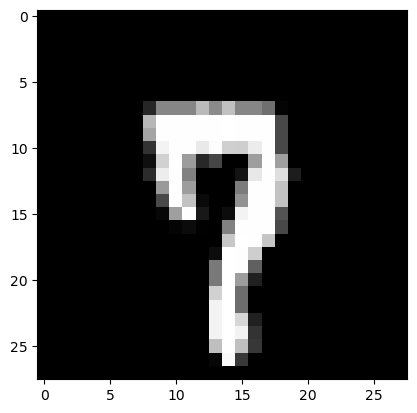

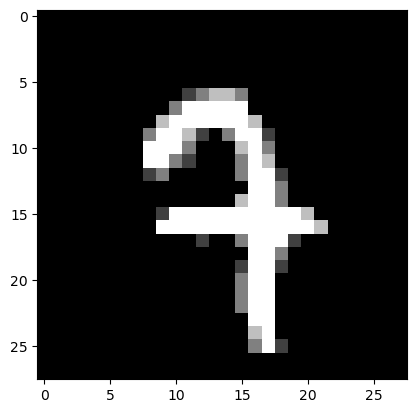

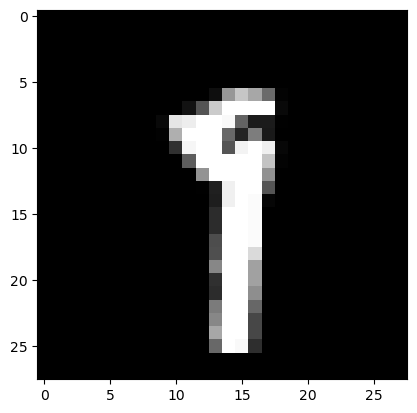

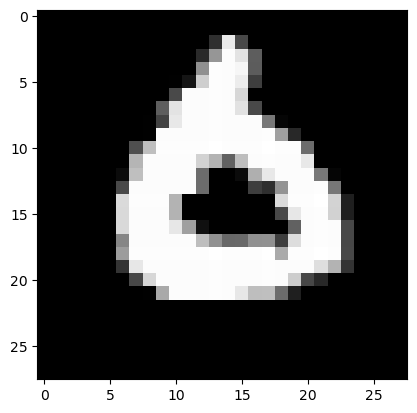

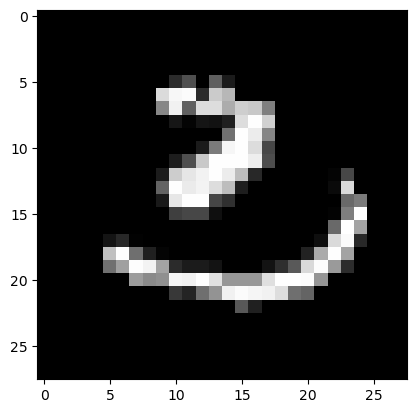

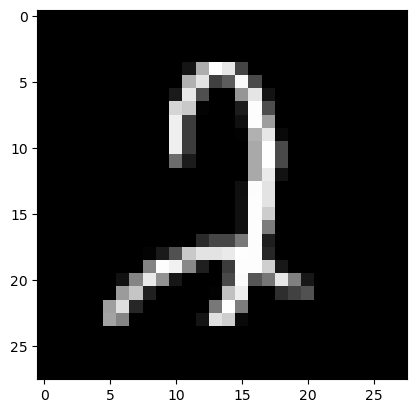

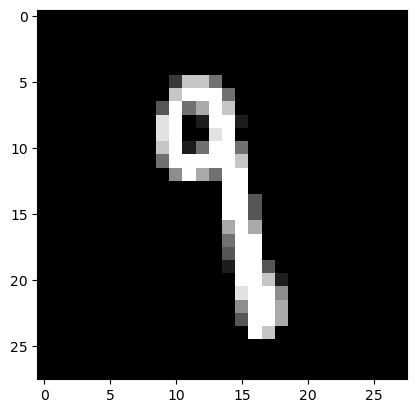

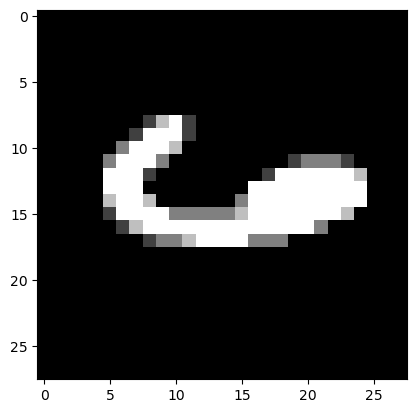

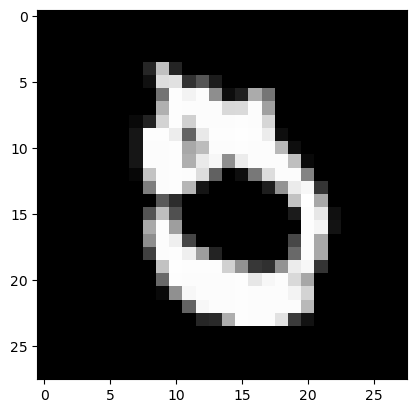

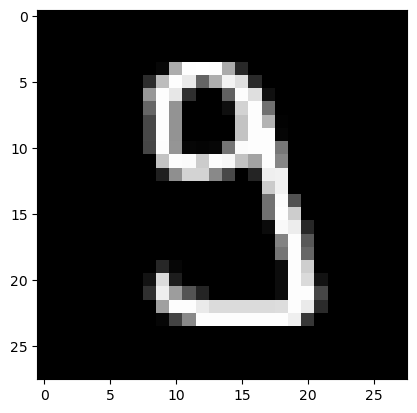

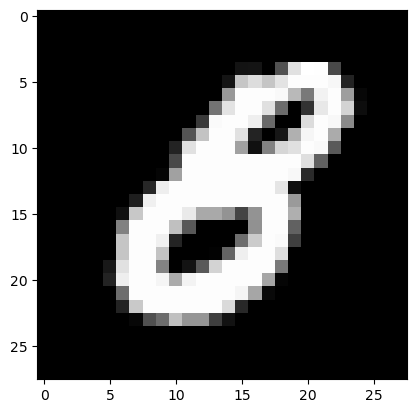

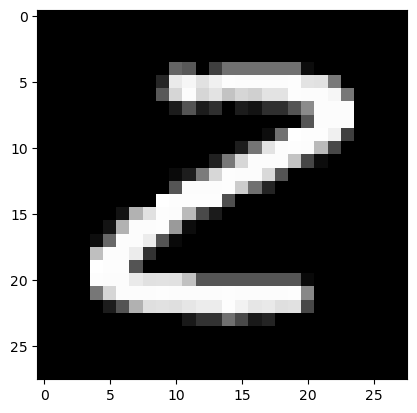

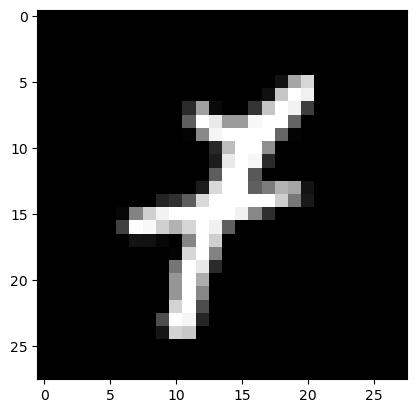

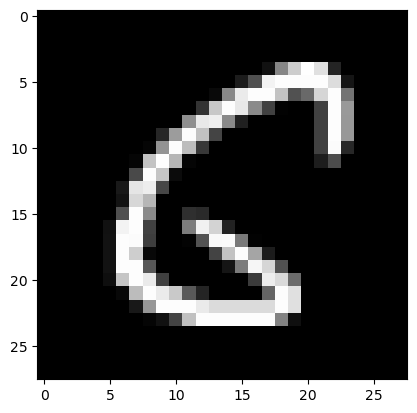

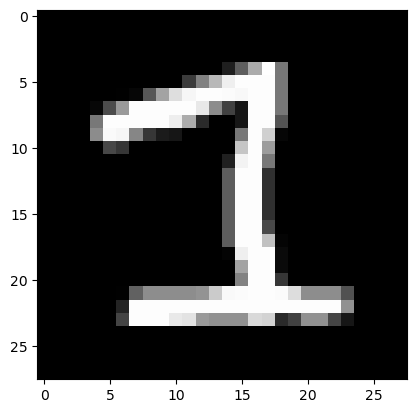

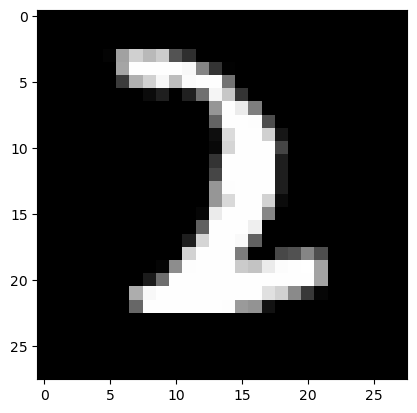

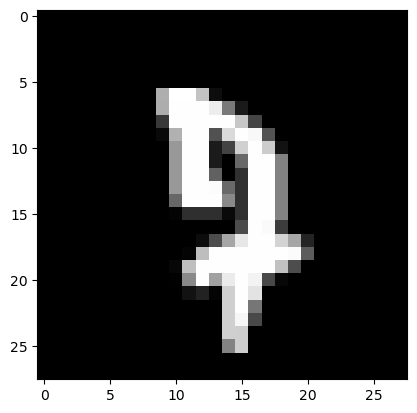

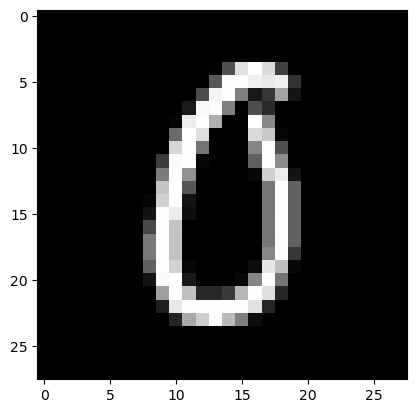

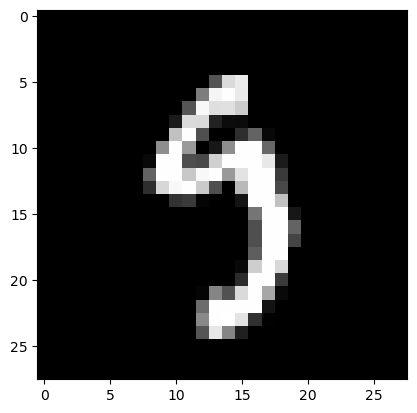

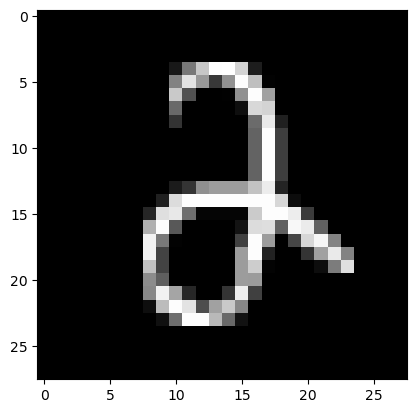

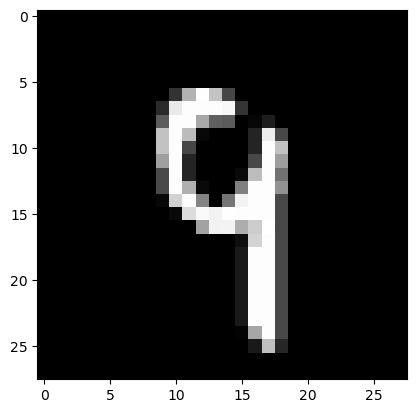

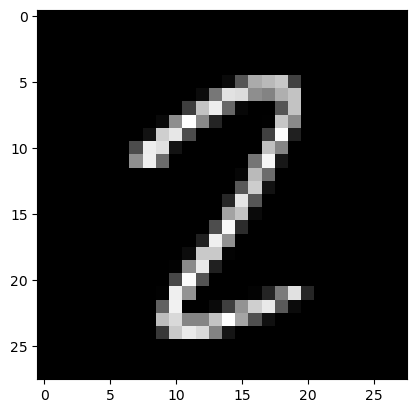

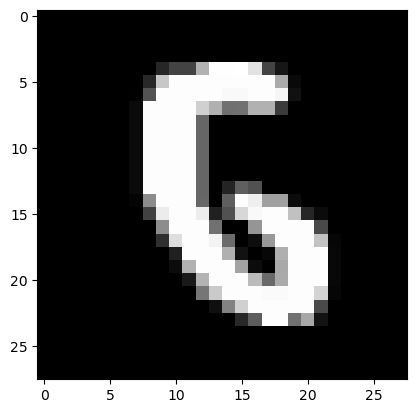

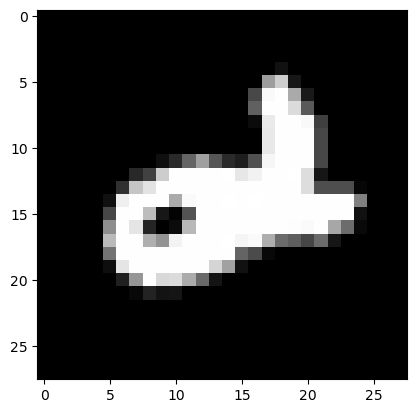

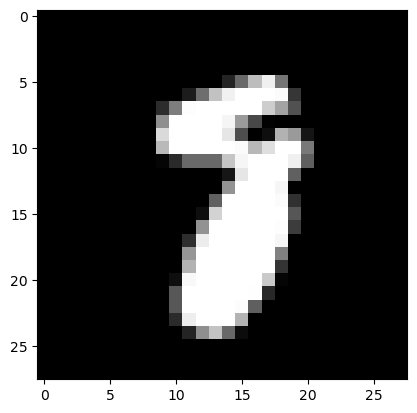

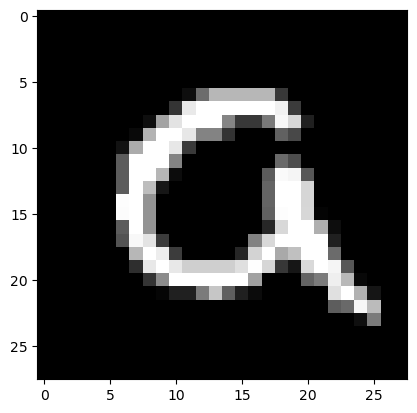

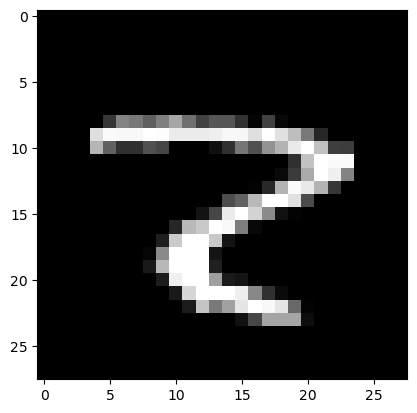

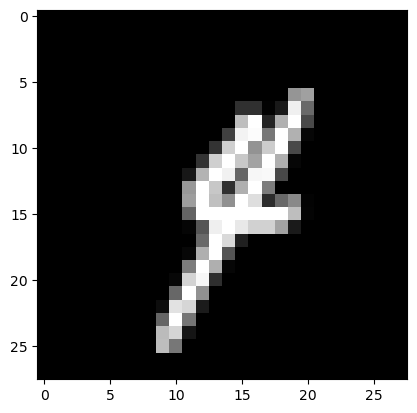

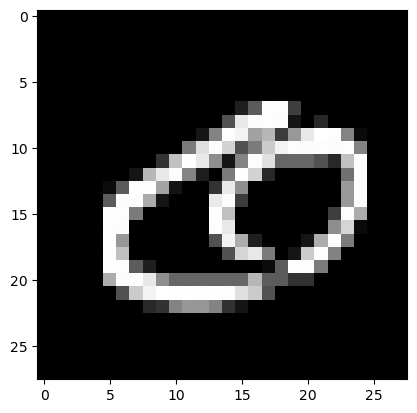

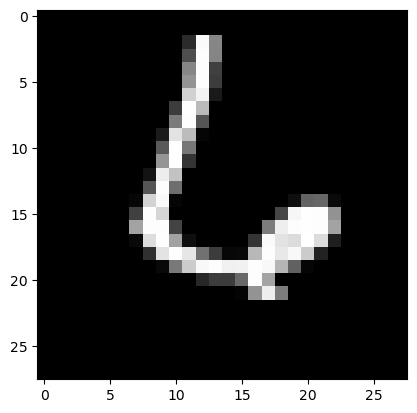

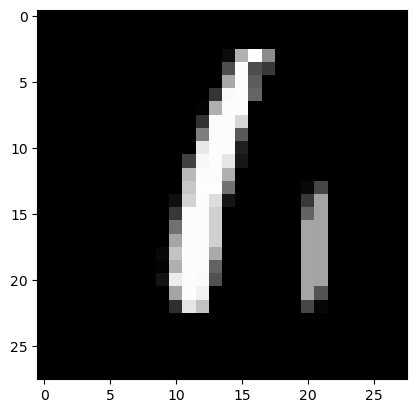

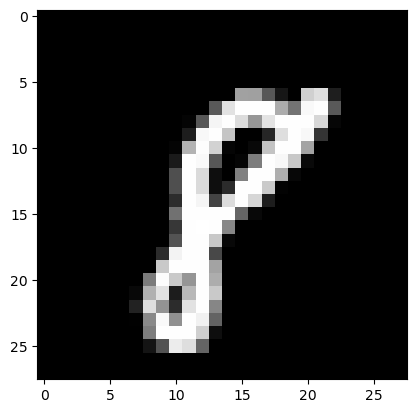

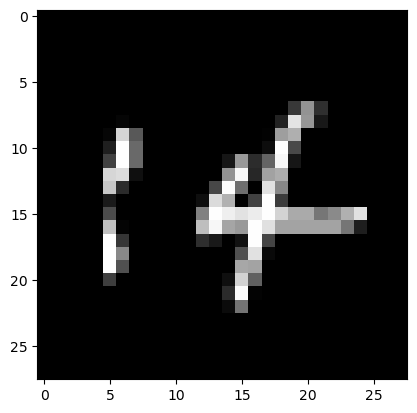

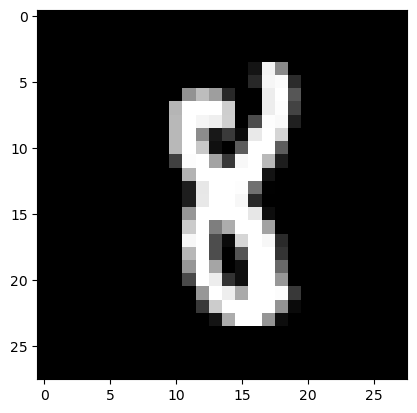

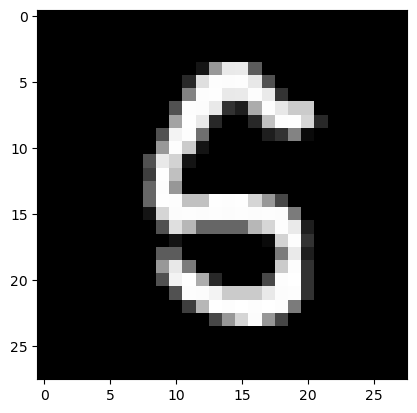

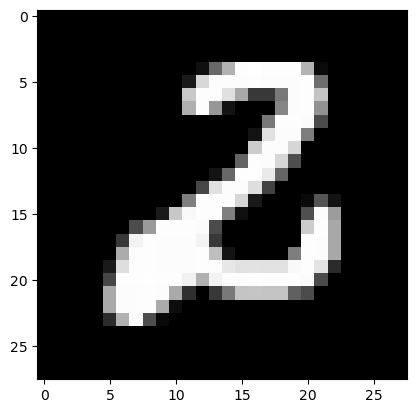

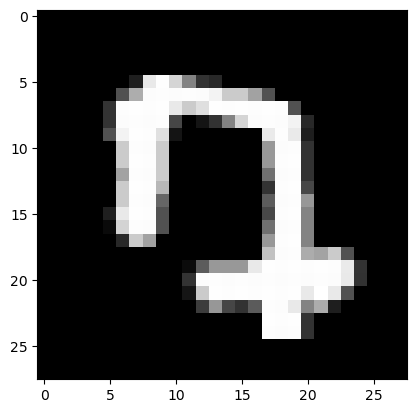

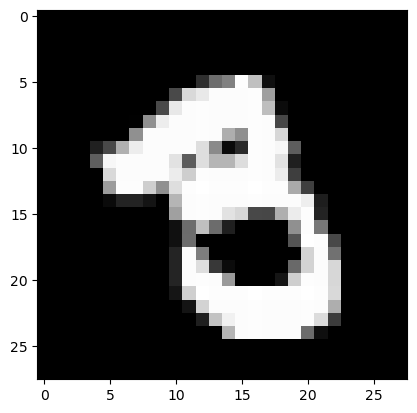

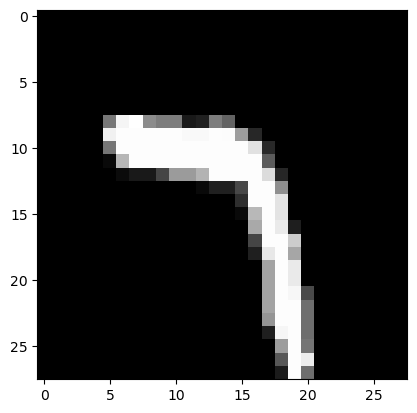

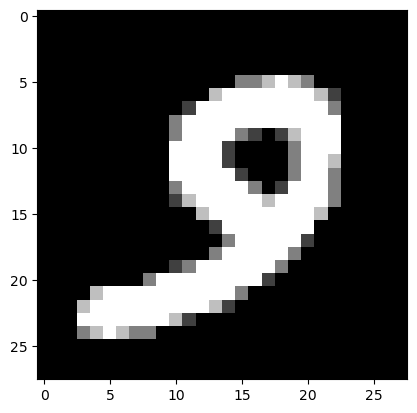

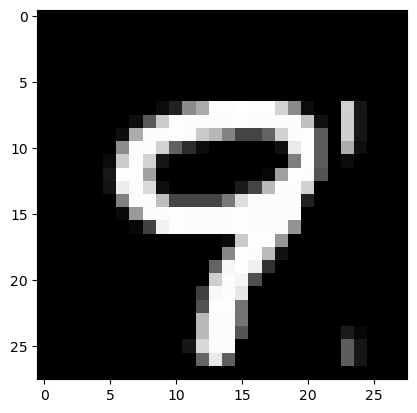

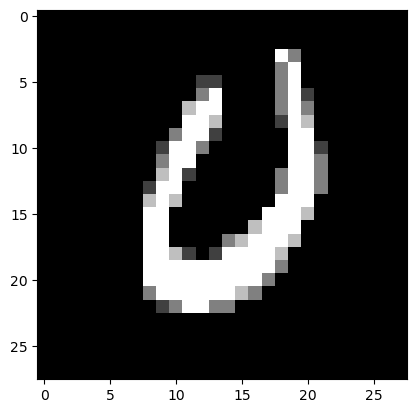

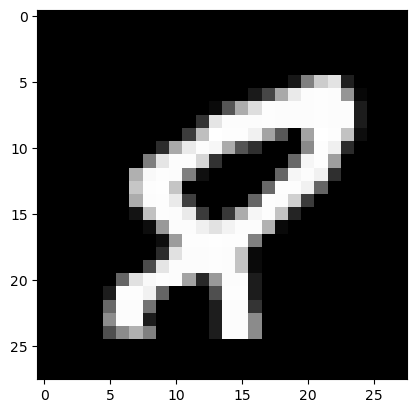

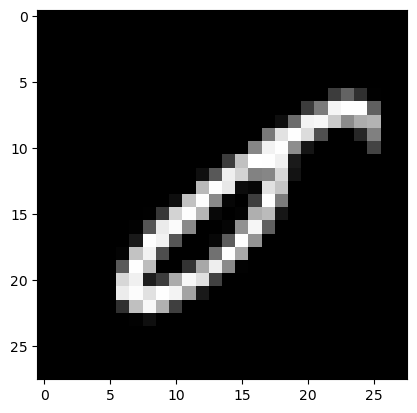

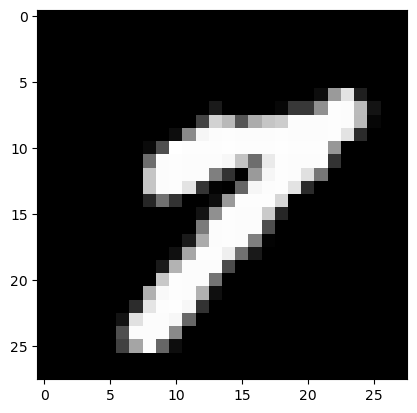

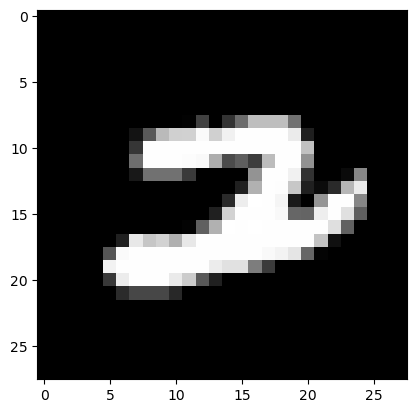

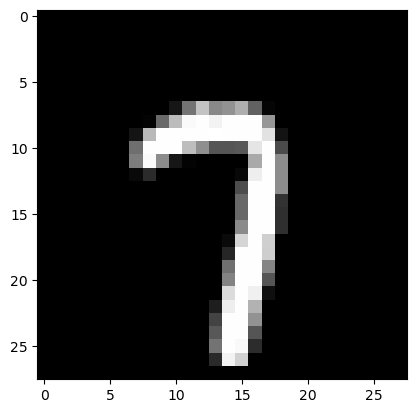

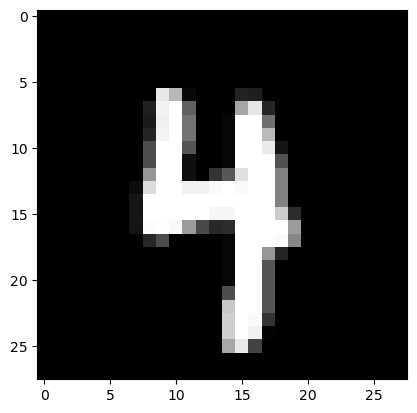

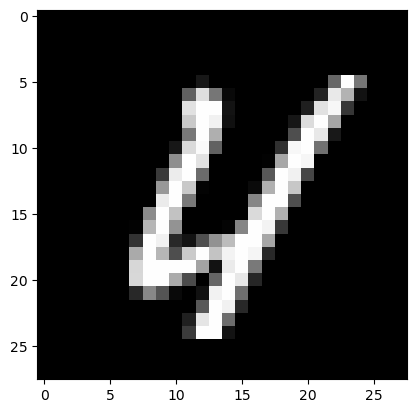

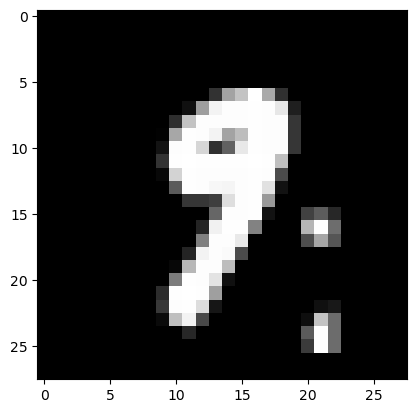

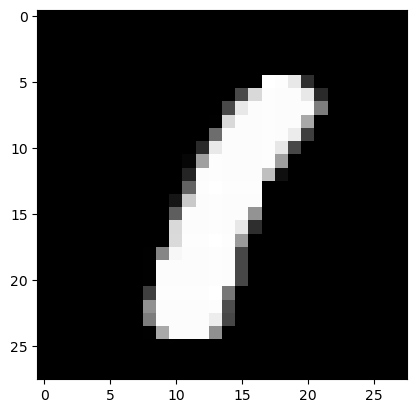

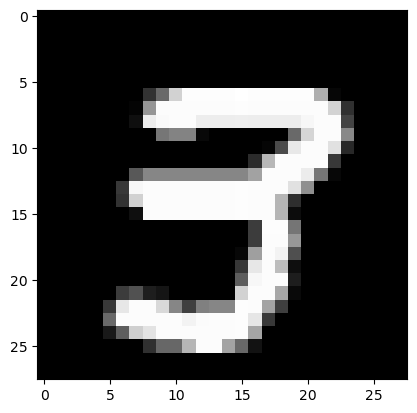

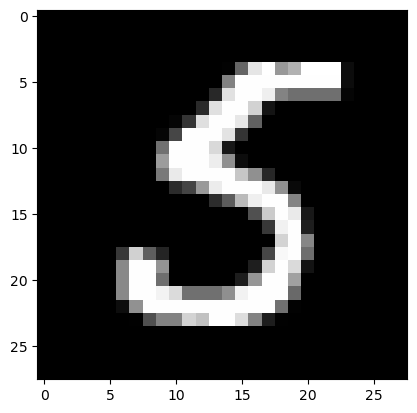

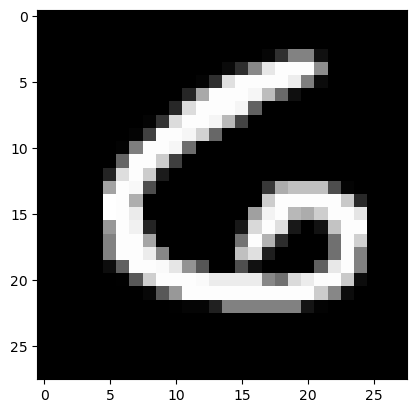

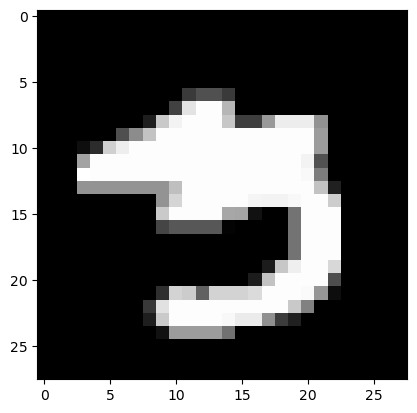

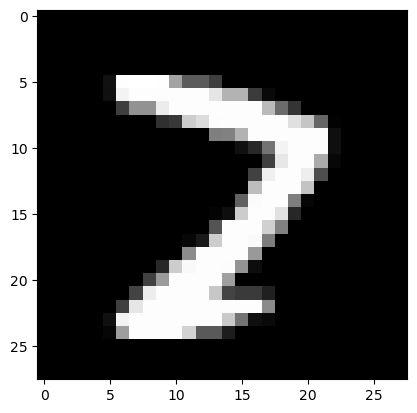

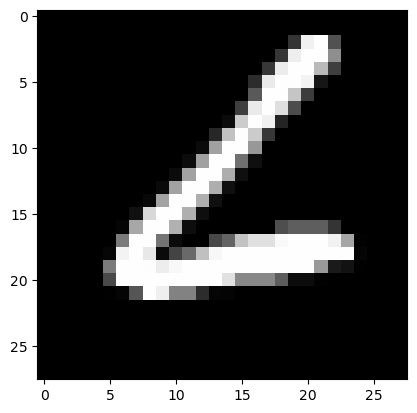

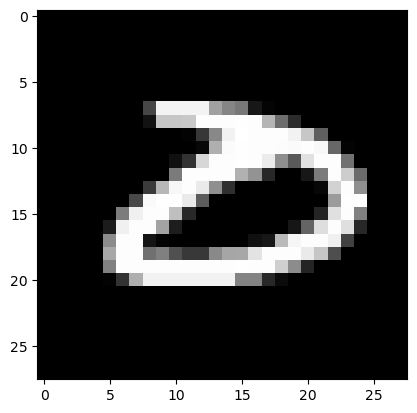

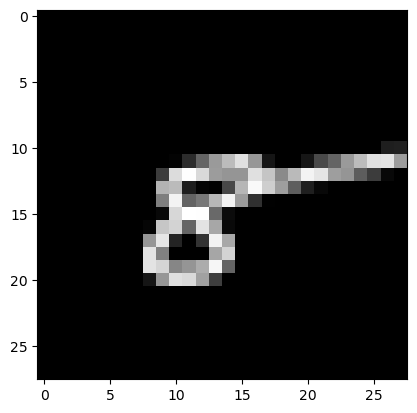

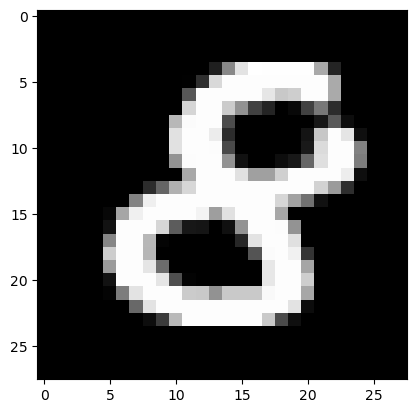

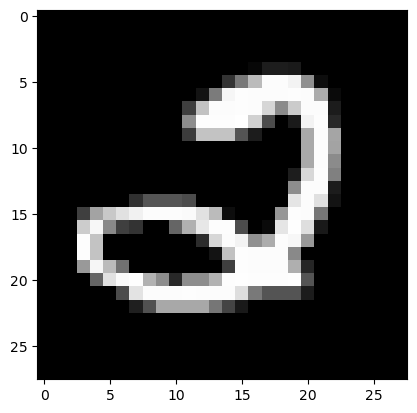

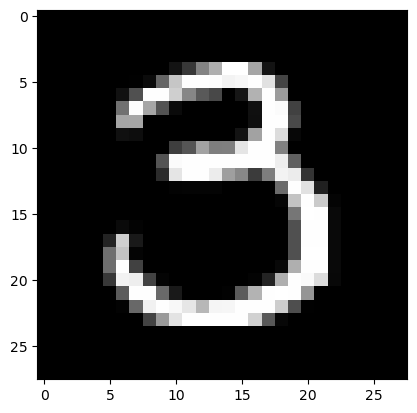

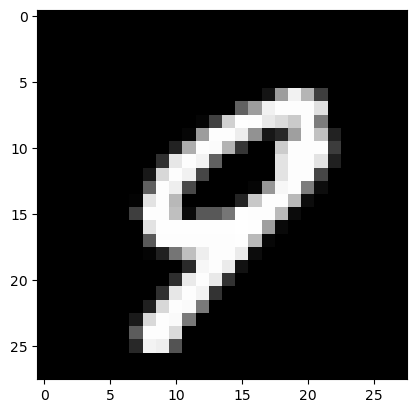

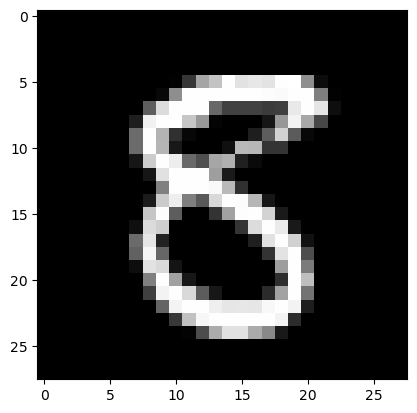

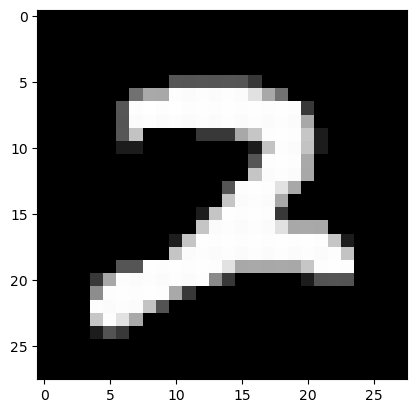

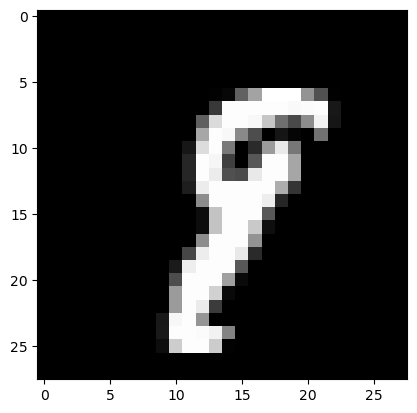

In [36]:
for i in range(len(missed_img)):
    missed_np = missed_img[i].numpy()
    plt.imshow(missed_np, 'gray')
    plt.show()